# No-Reference Forest Loss Classification Using Supervised Learning
Kornelia Noculak, Jakub Wąsala (2025)

In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import ee
import geemap
import pandas as pd


from src.geojson import export_forest_loss_to_geojson
from src.metrics import prepare_results, calculate_metrics, plot_confusion_matrices
from src.training import extract_training_data, train_classifier
from src.visualizations import (
    classify_and_subtract,
    create_labeled_image,
    show_training_samples,
    visualize_forest_change,
)


ee.Authenticate()
ee.Initialize()

## 1. Introduction & Ground Truth Dataset

Problem:
* Deforestation is a major environmental issue that has a significant impact on the global climate and biodiversity.
* Existing datasets (i.e. Hansen year loss) provide ground truth information about forest loss, but:
    - they are not always up to date,
    - provide information about tree loss with precision only up to fully rounded year.

In [4]:
visualize_forest_change(2022)

Map(center=[52.108736119738694, 19.430639807941635], controls=(WidgetControl(options=['position', 'transparent…

In [5]:
export_forest_loss_to_geojson(2020, "forest_loss_2020.geojson")

Generating URL ...
Please wait ...
Data downloaded to /Users/jakub/AI/Z24/GEO/pdp-forest-logging/forest_loss_2020.geojson


## 2. Data preprocessing

### 2.1. Setting up hyperparameters

* We use a pair of hyperparameters `MIN_DEFORESTATION` and `REFERENCE_YEAR` to select patches of forest loss
* We use satellite data from `REFERENCE_YEAR` to train classifier to detect forest loss
* `TRAINING_PATCH` is a polygon within Poland that we use for training

In [6]:
MIN_DEFORESTATION_YEAR = 2016
REFERENCE_YEAR = 2020
FOREST_COVER_THRESHOLD = 50
TRAINING_PATCH = ee.Geometry.Polygon(
    [[17.5, 50.5], [17.5, 51.2], [19.3, 51.2], [19.3, 50.5]]
)
TRAIN_TEST_SPLIT = 0.8
BOUNDING_BOX_BUFFER_METERS = 1000

### 2.2. Showing the training set

* We show entire area of training
* For training, we use only a single year and a small patch of Poland region

In [7]:
labeled = create_labeled_image(
    TRAINING_PATCH, MIN_DEFORESTATION_YEAR, REFERENCE_YEAR, FOREST_COVER_THRESHOLD
)

map = geemap.Map()

map.centerObject(TRAINING_PATCH, 12)
map.addLayer(labeled, {"min": 0, "max": 2, "palette": ["black", "green", "red"]})
map

Map(center=[50.85258536025442, 18.399999999999924], controls=(WidgetControl(options=['position', 'transparent_…

### 2.3. Sampling training pixels
* Classifier requires training data as a set of pixels with labels
* Balanced vs unbalanced: balanced classes give better training results, but require to sample more pixels in the first place

In [11]:
poland_fc = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(
    ee.Filter.eq("ADM0_NAME", "Poland")
)
region_for_training = poland_fc.geometry().intersection(TRAINING_PATCH)
sat_image, labeled_image, train_points, test_points = extract_training_data(
    region_for_training,
    MIN_DEFORESTATION_YEAR,
    REFERENCE_YEAR,
    FOREST_COVER_THRESHOLD,
    TRAIN_TEST_SPLIT,
    balanced=True,
    num_pixels=10000,
)
hansen_data = ee.Image("UMD/hansen/global_forest_change_2023_v1_11").clip(
    region_for_training
)

Balanced points count: 199 (per class)


In [12]:
show_training_samples(sat_image, train_points, test_points)

Map(center=[50.84135477627695, 18.392773762951496], controls=(WidgetControl(options=['position', 'transparent_…

### 2.4. Training classifiers

* We use a set of Earth Engine built-in classifiers with different hyperparameters
* Classifiers use all bands from the satellite image to increase accuracy

In [14]:
bands = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B10", "B11", "B12"]

classifiers = {
    # "Random Forest n=50": ee.Classifier.smileRandomForest(numberOfTrees=50),
    # "Random Forest n=100": ee.Classifier.smileRandomForest(numberOfTrees=100),
    "Random Forest n=200": ee.Classifier.smileRandomForest(numberOfTrees=200),
    # "Random Forest n=500": ee.Classifier.smileRandomForest(numberOfTrees=500),
    # "Gradient Tree Boosting n=50": ee.Classifier.smileGradientTreeBoost(
    #      numberOfTrees=50
    #  ),
    # "Gradient Tree Boosting n=100": ee.Classifier.smileGradientTreeBoost(
    #     numberOfTrees=100
    # ),
    # "Gradient Tree Boosting n=200": ee.Classifier.smileGradientTreeBoost(
    #     numberOfTrees=200
    # ),
    # "Gradient Tree Boosting n=500": ee.Classifier.smileGradientTreeBoost(
    #     numberOfTrees=500
    # ),
    # "SVM": ee.Classifier.libsvm(),
    # "k-NN k=3": ee.Classifier.smileKNN(k=3),
    # "k-NN k=5": ee.Classifier.smileKNN(k=5),
    # "k-NN k=7": ee.Classifier.smileKNN(k=7),
}

for classifier_name in classifiers.keys():
    print(f"==================== {classifier_name} ====================")
    classifiers[classifier_name] = train_classifier(
        train_points, test_points, bands, classifiers[classifier_name], train_suite_name="mini"
    )
    print("============================================================")

==================== Random Forest n=200 ====================
Training classifier...
Saving classifier as: type_Classifier_smileRandomForest_numberOfTrees_200
Evaluating metrics...
Confusion matrix (train): [[156, 1, 0], [0, 157, 0], [0, 1, 165]]
Accuracy (train): 0.9958333333333333
Confusion matrix (test): [[41, 3, 3], [1, 33, 4], [11, 6, 14]]
Accuracy (test): 0.7586206896551724


In [24]:
import pickle


with open(
    "models_final/type_Classifier_smileRandomForest_numberOfTrees_100.pkl", "rb"
) as f:
    best_classifier = pickle.load(f)

## 3. Results

* We use histogram-matching under the hood to bring images from any year to similar values to the year the classifier was trained on
* We show that we can use the classifier to compare forest loss in following years in order to visualize recent forest loss

In [28]:
classify_and_subtract(best_classifier, bands, BOUNDING_BOX_BUFFER_METERS, 2019, 2022, FOREST_COVER_THRESHOLD)

Wczytuję dane i generuję klasyfikację dla całej Polski...


Map(center=[52.108736119738694, 19.430639807941635], controls=(WidgetControl(options=['position', 'transparent…

In [32]:
df = prepare_results()

df[["precision_train", "recall_train", "f1_macro_train"]] = df["conf_matrix_train"].apply(lambda cm: calculate_metrics(cm)).apply(pd.Series)
df[["precision_test", "recall_test", "f1_macro_test"]] = df["conf_matrix_test"].apply(lambda cm: calculate_metrics(cm)).apply(pd.Series)

df[["name", "precision_train", "recall_train", "f1_macro_train", "accuracy_train", "precision_test", "recall_test", "f1_macro_test", "accuracy_test"]].sort_values(by="f1_macro_test", ascending=False).round(2)

[[3588, 133, 67], [66, 3545, 116], [108, 167, 3454]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3788
           1       0.92      0.95      0.94      3727
           2       0.95      0.93      0.94      3729

    accuracy                           0.94     11244
   macro avg       0.94      0.94      0.94     11244
weighted avg       0.94      0.94      0.94     11244

[[3782, 7, 2], [3, 3720, 9], [11, 9, 3718]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3791
           1       1.00      1.00      1.00      3732
           2       1.00      0.99      1.00      3738

    accuracy                           1.00     11261
   macro avg       1.00      1.00      1.00     11261
weighted avg       1.00      1.00      1.00     11261

[[3714, 55, 22], [34, 3653, 45], [57, 48, 3633]]
              precision    recall  f1-score   support

           0       0.98      0.98    

,name,precision_train,recall_train,f1_macro_train,accuracy_train,precision_test,recall_test,f1_macro_test,accuracy_test
4,smileRandomForest_numberOfTrees_50,0.99,0.99,0.99,0.99,0.78,0.78,0.78,0.77
2,smileGradientTreeBoost_numberOfTrees_200,0.98,0.98,0.98,0.98,0.78,0.77,0.77,0.78
7,smileRandomForest_numberOfTrees_500,1.00,1.00,1.00,1.00,0.77,0.77,0.77,0.77
1,smileRandomForest_numberOfTrees_200,1.00,1.00,1.00,1.00,0.77,0.77,0.77,0.77
3,smileRandomForest_numberOfTrees_100,0.99,0.99,0.99,0.99,0.77,0.77,0.77,0.77
0,smileGradientTreeBoost_numberOfTrees_50,0.94,0.94,0.94,0.94,0.77,0.77,0.77,0.77
6,smileGradientTreeBoost_numberOfTrees_100,0.96,0.96,0.96,0.96,0.77,0.77,0.77,0.77
5,smileKNN_k_3,0.84,0.84,0.84,0.84,0.72,0.72,0.72,0.72


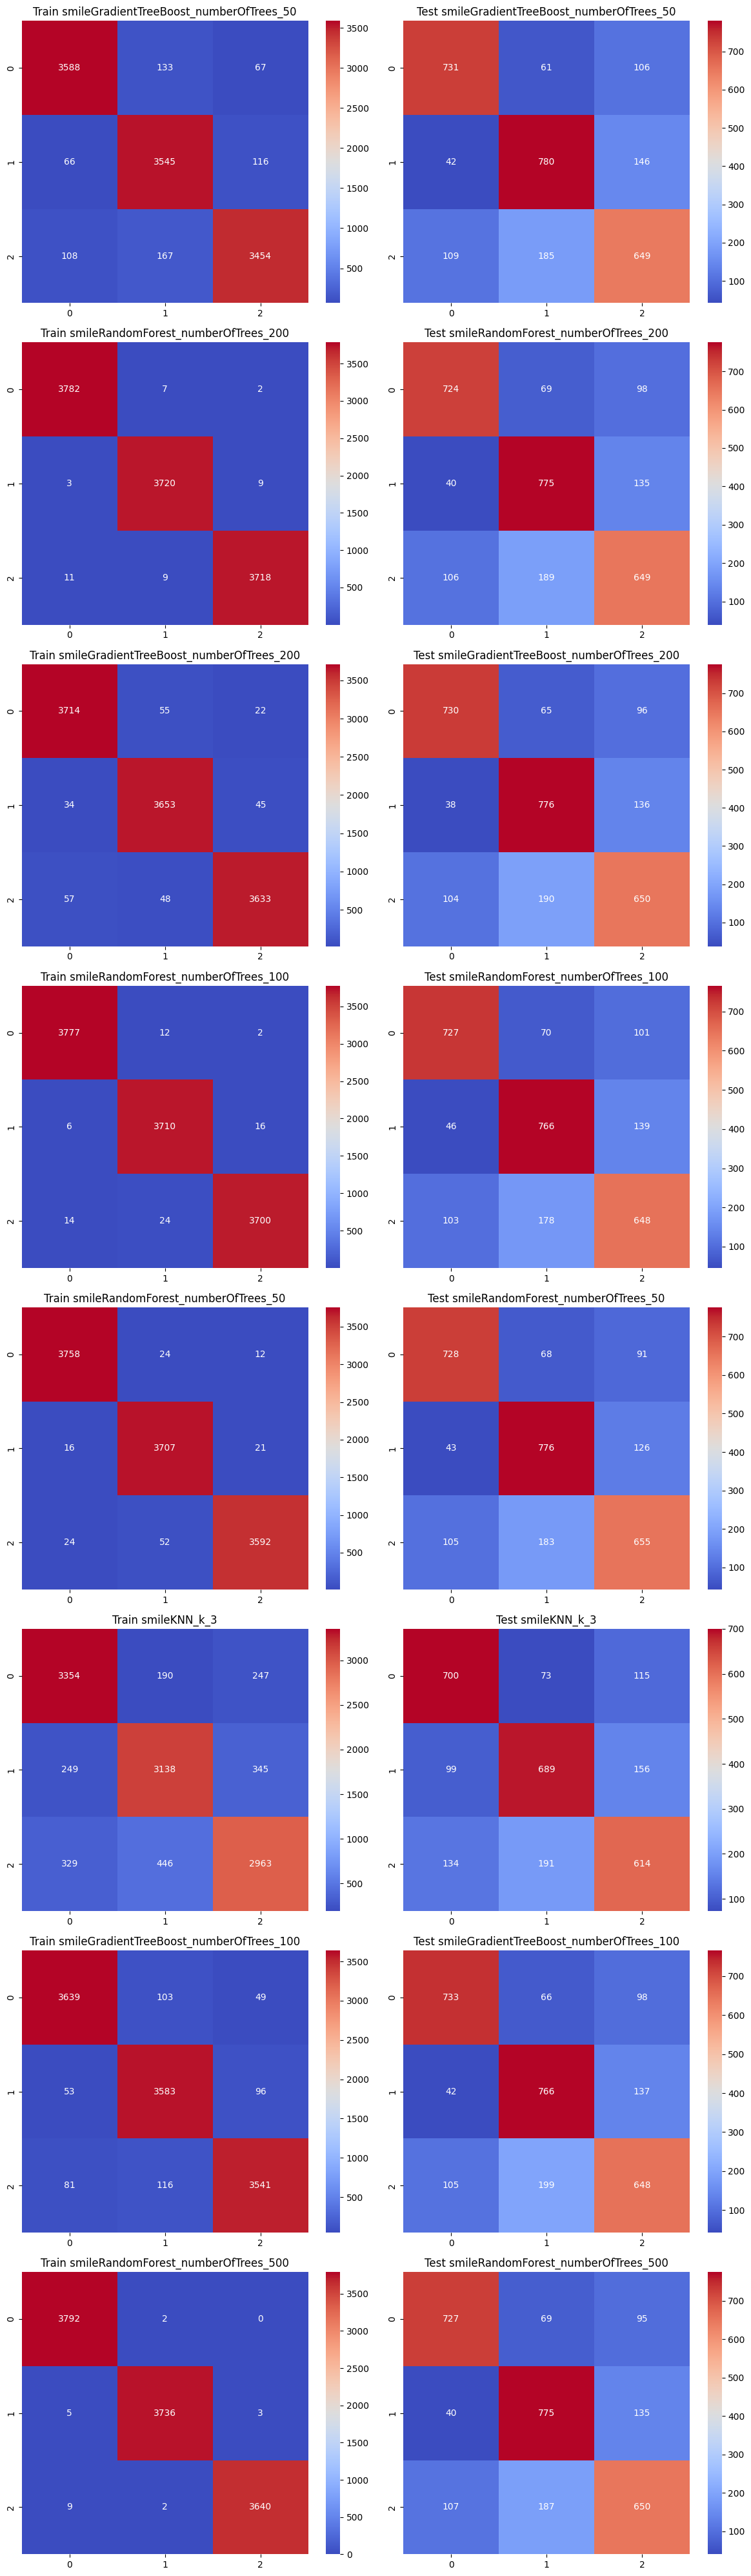

In [42]:
plot_confusion_matrices(df)

## 4. Conclusions
* We show that it is possible to train a classifier to detect forest loss using only a single year of data.
* Our classifier is able to perform detection without any reference to previous years, which is a significant improvement over existing methods.
* The accuracy of the classifier is not yet perfect, but it is sufficient to help detect forest loss in the following years.
* We suggest that further research should focus on improving the accuracy of the classifier and expanding the dataset to include more regions and years.

## 5. References

* Hansen, M. C., P. V. Potapov, R. Moore, M. Hancher, S. A. Turubanova, A. Tyukavina, D. Thau, S. V. Stehman, S. J. Goetz, T. R. Loveland, A. Kommareddy, A. Egorov, L. Chini, C. O. Justice, and J. R. G. Townshend. 2013. "High-Resolution Global Maps of 21st-Century Forest Cover Change." Science 342 (15 November): 850-53. 10.1126/science.1244693 Data available on-line at: https://glad.earthengine.app/view/global-forest-change.